In [4]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

In [5]:
import torch
print(torch.cuda.is_available())
# Load the SAM model as we have seen in the class
# Remeber to load it on the GPU by adding .to("cuda")
# at the end
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")

# Load the SamProcessor using the facebook/sam-vit-base
# checkpoint
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

True


In [6]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization.
    Colors the masked area in green with some transparency.
    """
    # Initialize an empty RGBA image (with transparency)
    bg_transparent = np.zeros(mask.shape + (4,), dtype=np.uint8)
    
    # Color the mask region green with some transparency
    # The vector [Red, Green, Blue, Alpha], where alpha=127 makes it semi-transparent
    bg_transparent[mask == 1] = [0, 255, 0, 127]
    
    return bg_transparent


def get_processed_inputs(image, input_points):
    """
    Processes the input image and points using the SAM processor, 
    runs the SAM model, and returns the best binary mask.
    """
    # Ensure the input image is of the correct type (PIL.Image)
    if not isinstance(image, Image.Image):
        raise ValueError("Input image must be a PIL.Image")

    # Use the processor to generate the inputs for SAM
    inputs = processor(images=image, input_points=input_points, return_tensors='pt').to("cuda")
    
    # Forward pass through the SAM model
    outputs = model(**inputs)
    
    # Post-process the outputs to get masks with the right size
    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),                 # Mask predictions from SAM
        inputs["original_sizes"].cpu(),           # Original sizes of the inputs
        inputs["reshaped_input_sizes"].cpu()      # Reshaped sizes of the inputs
    )
    
    # Select the best mask based on the highest IoU score (confidence)
    best_mask = masks[0][0][outputs.iou_scores.argmax()]
    
    # Invert the mask so that the subject is 0 (black) and background is 1 (white)
    # This will be helpful for inpainting the background
    inverted_mask = ~best_mask.cpu().numpy()
    
    return inverted_mask

In [7]:
# Correct the raw_image loading, ensure it's a valid PIL Image
raw_image = Image.open("car.png").convert("RGB").resize((512, 512))

# These are the coordinates of two points on the car
input_points = [[[150, 170], [300, 250]]]

# Get the mask from the processed inputs
mask = get_processed_inputs(raw_image, input_points)

# Convert the mask to an RGB image and resize it for visualization
Image.fromarray(mask_to_rgb(mask)).resize((128, 128)).show()

In [8]:
from diffusers import AutoPipelineForInpainting
import torch

# Load the AutoPipelineForInpainting pipeline
pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16  # Set the dtype to float16 for efficiency
).to("cuda")

# Enable model CPU offloading for better memory efficiency
pipeline.enable_model_cpu_offload()

print("Pipeline loaded and CPU offloading enabled.")



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Pipeline loaded and CPU offloading enabled.


In [9]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    # Convert the input mask to a PIL Image
    mask_image = Image.fromarray(input_mask)
    
    # Set up the random generator with the specified seed
    rand_gen = torch.manual_seed(seed)
    
    # Use the pipeline to perform inpainting
    image = pipeline(
        prompt=prompt,                   # Main prompt for inpainting
        negative_prompt=negative_prompt, # Optional negative prompt
        image=raw_image,                 # Image to inpaint
        mask_image=mask_image,           # Mask specifying the inpainting region
        generator=rand_gen,              # Random generator for reproducibility
        guidance_scale=cfgs              # Configurable guidance scale
    ).images[0]  # Extract the first image from the result
    
    return image


In [10]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

P:\Generative_AI\venv\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/49 [00:00<?, ?it/s]

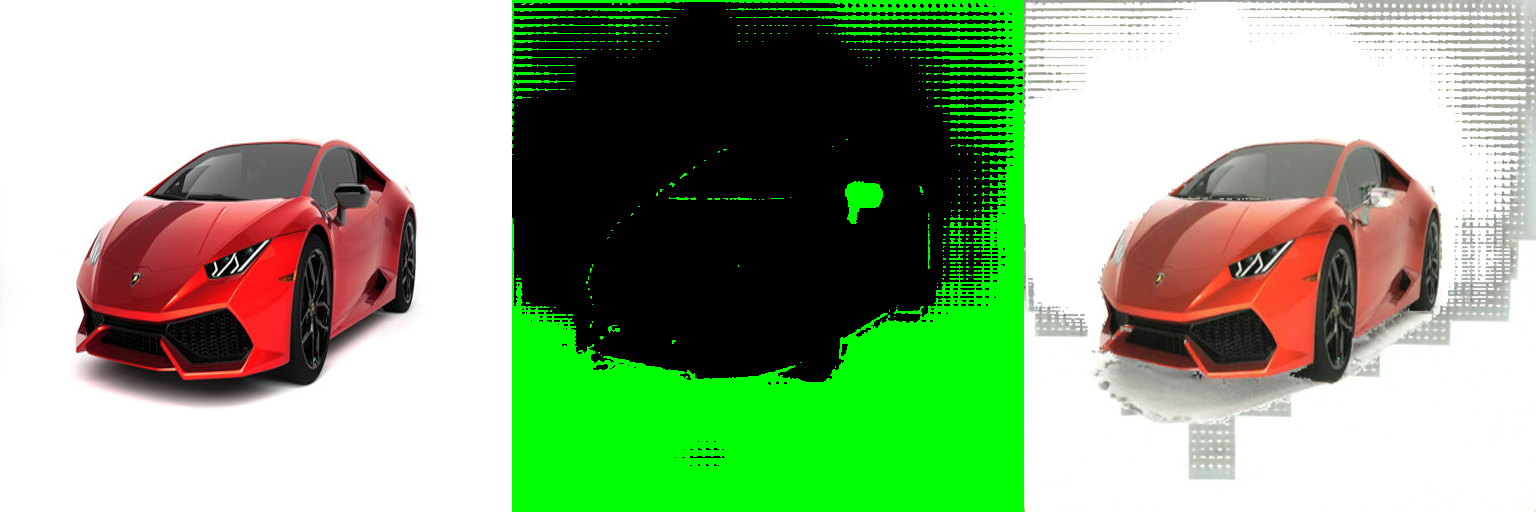

In [11]:
fig = make_image_grid([raw_image, Image.fromarray(mask_to_rgb(mask)), image.resize((512, 512))], rows=1, cols=3)
fig

In [12]:
import gradio as gr
import torch
from PIL import Image

def segment_and_inpaint(image, input_points_str, prompt):
    # Convert input points from string to list of lists of floats
    try:
        input_points = eval(input_points_str)
        # Ensure input_points are floating points
        input_points = [[[float(coord) for coord in point] for point in points] for points in input_points]
    except:
        return "Error: Invalid input points format. Expected format is [[[x1, y1], [x2, y2]]]"

    # Generate mask using SAM
    mask = get_processed_inputs(image, input_points)
    
    # Perform inpainting with the user-defined prompt
    inpainted_image = inpaint(image, mask, prompt)
    
    # Return original, mask, and inpainted image as 3 panels
    return image, Image.fromarray(mask_to_rgb(mask)), inpainted_image

# Create the Gradio app
iface = gr.Interface(
    fn=segment_and_inpaint,
    inputs=[
        gr.Image(type="pil"),
        gr.Textbox(label="Input Points (e.g., [[[150.0, 170.0], [300.0, 250.0]]])"),
        gr.Textbox(label="Inpainting Prompt (e.g., 'Mars landscape')")
    ],
    outputs=["image", "image", "image"],
    title="Segment and Inpaint",
    description="Upload an image, input points for segmentation, and enter a text prompt for inpainting the background."
)

# Launch the app
iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a10774c8a082a3205e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "P:\Generative_AI\venv\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 406, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "P:\Generative_AI\venv\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 70, in __call__
    return await self.app(scope, receive, send)
  File "P:\Generative_AI\venv\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "P:\Generative_AI\venv\lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "P:\Generative_AI\venv\lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "P:\Generative_AI\venv\lib\site-packages\starlette\middleware\errors.py", line 165, in __call__
    await self.app(scope, receive, _send)
  File "P:\Generative_AI\venv\lib\site-pack

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]